In [259]:
# Setup matplotlib.  
from IPython import get_ipython
if get_ipython() is not None: get_ipython().run_line_magic("matplotlib", "inline")

In [260]:
import pydrake
# python libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pydrake.all import (VectorSystem, DiagramBuilder, SymbolicVectorSystem, LogVectorOutput,MathematicalProgram,
                         Variable, Simulator, cos, sin, ToLatex, Variable, Variables, Polynomial, Solve)
from math import pi          
import math               

In [261]:

# state of the robot (in cartesian coordinates)
x = Variable("x")          # 
y = Variable("y")          #  
theta = Variable("theta")  # vehicle orienttaion
 
cartesian_state = [x, y, theta]

# control input of the robot
v = Variable("v") # driving velocity input
delta = Variable("delta") # steering velocity input
input = [v, delta]

# nonlinear dynamics, the whole state is measured (output = state)
dynamics = [v * cos(theta), 
            v * sin(theta), 
            delta]

robot = SymbolicVectorSystem(
    state=cartesian_state,
    input=input,
    output=cartesian_state,
    dynamics=dynamics,
)

def clip(val, min_, max_):
    return min_ if val < min_ else max_ if val > max_ else val

In [262]:
class ParkingController(VectorSystem):

    def __init__(self, lyapunov_controller):
        # 4 inputs (robot state)
        # 2 outputs (robot inputs)
        VectorSystem.__init__(self, 3, 2)
        self.lyapunov_controller = lyapunov_controller

    def euc(self, x, y, x_obs, y_obs):
      # x and y are vehicle pose
      return math.sqrt((x-x_obs)**2) + ((y-y_obs)**2)

    def DoCalcVectorOutput(
            self,
            context,          # not used
            cartesian_state,  # input of the controller
            controller_state, # not used
            input             # output of the controller
        ):
      
        # upack state of the robot
        z1, z2, z3 = cartesian_state

        target_x, target_y, target_theta = 10,0,0

        # state in polar coordinates
        e = np.sqrt((z1-target_x)**2 + (z2-target_y)**2)            # radial coordinate
        goal_heading = np.arctan2((z2-target_y), (z1-target_x))     # angular coordinate
        a = goal_heading - z3

        
        # evaluate the function below and return the robot's input
        input[:] = self.lyapunov_controller(e,a,target_theta)
 

In [263]:
def lyapunov_controller(e,a,target_theta):

    if abs(a < 0.1):
      u1 = -e * cos(a)
      u2 =  a + (1)*(a+target_theta)
    else:
      u1 = -e * cos(a)
      u2 =  a + (cos(a)*sin(a) / a)*(a+target_theta)

    if e < 0.1:
      u1, u2 = 0,0

    return clip(u1,-1.5,1.5), clip(u2,-0.6,0.6)

In [264]:
builder = DiagramBuilder()

# add the robot to the diagram
# the method .AddSystem() simply returns a pointer to the system
# we passed as input, so it's ok to give it the same name
robot = builder.AddSystem(robot)

# add the controller
controller = builder.AddSystem(ParkingController(lyapunov_controller))

# wire the controller with the system
builder.Connect(robot.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), robot.get_input_port(0))

# add a logger to the diagram
# this will store the state trajectory
logger = LogVectorOutput(robot.get_output_port(0), builder)

# complete the construction of the diagram
diagram = builder.Build()
# set up a simulation environment
simulator = Simulator(diagram)

# set the initial cartesian state to a random initial position
# try initial_state = np.random.randn(3) for a random initial state
initial_state = [-10,0,0] 
context = simulator.get_mutable_context()
context.SetContinuousState(initial_state)

# simulate from zero to sim_time
# the trajectory will be stored in the logger
integrator = simulator.get_mutable_integrator()
target_accuracy = 1E-1
integrator.set_target_accuracy(target_accuracy)

maximum_step_size = 0.2
integrator.set_maximum_step_size(maximum_step_size)

minimum_step_size = 2E-5
integrator.set_requested_minimum_step_size(minimum_step_size)

integrator.set_throw_on_minimum_step_size_violation(True)
 
integrator.set_fixed_step_mode(True)

sim_time = 20.0
simulator.AdvanceTo(sim_time)

In [265]:
# vehicle size in the plot
length = .6
width = .3

# function that draws a triangle given the cartesian state of the robot
def draw_robot(cartesian_state, **kwargs):
    
    # transformation matrix from global to robot frame
    z1, z2, z3 = cartesian_state
    T = np.array([
        [np.cos(z3), -np.sin(z3), z1],
        [np.sin(z3), np.cos(z3), z2]
    ])

    # compute cartesian coordinates of the corners of the car
    left_back = T.dot([-length/2, width/2, 1])
    right_back = T.dot([-length/2, -width/2, 1])
    left_front = T.dot([length/2, width/2,  1])
    right_front = T.dot([length/2, -width/2,  1])

    heading_arrow_tail = T.dot([length/2,0,1])
    heading_arrow_head = T.dot([length,0,1])
    
    # draw a triangle that symbolizes the robot
    robot = patches.Polygon(
        np.vstack([heading_arrow_head, heading_arrow_tail, left_front, left_back, right_back, right_front, heading_arrow_tail]),
        facecolor='none',
        **kwargs
    )

    obstacle = patches.Ellipse((5,5),1.0,1.0)
 
    plt.gca().add_patch(robot)
    plt.gca().add_patch(obstacle)


# function that draws the trajectory of the robot
# initial and final states are red and blue, respectively
def draw_trajectory(trajectory):

    # draw trajectory of the robot in black
    for state in trajectory.T:
        draw_robot(state, edgecolor='k')
        
    # draw initial configuration of the robot in red
    draw_robot(
        trajectory[:,0],
        edgecolor='r',
        linewidth=3,
        label='Initial configuration'
    )

    # draw final configuration of the robot in blue
    draw_robot(
        trajectory[:,-1],
        edgecolor='b',
        linewidth=3,
        label='Final configuration'
    )

Text(0.5, 1.0, 'Robot parking trajectory')

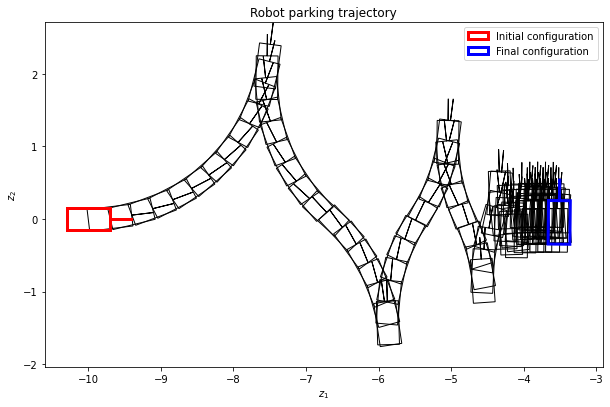

In [266]:
log = logger.FindLog(context)

# draw parking trajectory
plt.figure(figsize=(10, 10))
draw_trajectory(log.data()[0:3])

# adapt figure limits to the trajectory
robot_size = max(length, width)
plt.xlim([
        min(log.data()[0,:]) - robot_size,
        max(log.data()[0,:]) + robot_size
])
plt.ylim([
        min(log.data()[1,:]) - robot_size,
        max(log.data()[1,:]) + robot_size
])

# misc plot settings
plt.gca().set_aspect('equal')
plt.legend()
plt.xlabel(r'$z_1$')
plt.ylabel(r'$z_2$')
plt.title('Robot parking trajectory')

In [267]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np

u, v = np.mgrid[-1*np.pi:1*np.pi:100j, -1*np.pi:1*np.pi:100j]
x = u
y = v

z = -1 *(np.cos(x)**2) * y**2 - x**2

fig = make_subplots(rows=1, cols=1,
                    specs=[[{'is_3d': True}]],
                    subplot_titles=['Color corresponds to z']
                    )

fig.add_trace(go.Surface(x=x, y=y, z=z, colorbar_x=-0.51), 1, 1)
fig.update_layout(title_text="Ring cyclide")
fig.show()

In [268]:
from IPython.display import Math, display

def sos_optimize():
    prog = MathematicalProgram()
    x = prog.NewIndeterminates(2, "x")
    f = [-x[0] - 2 * x[1]**2, -x[1] - x[0] * x[1] - 2 * x[1]**3]

    V = prog.NewSosPolynomial(Variables(x), 2)[0].ToExpression()
    print("Candidate:")
    display(Math("V(x) = " + ToLatex(V)))
    prog.AddLinearConstraint(V.Substitute({x[0]: 0, x[1]: 0}) == 0)
    prog.AddLinearConstraint(V.Substitute({x[0]: 1, x[1]: 0}) == 1)
    Vdot = V.Jacobian(x).dot(f)

    prog.AddSosConstraint(-Vdot)

    result = Solve(prog)
    assert result.is_success()

    print("Solution:")
    display(Math("V(x) = " + ToLatex(
        Polynomial(result.GetSolution(V)).RemoveTermsWithSmallCoefficients(1e-5).ToExpression(),6)))


sos_optimize()

Candidate:


<IPython.core.display.Math object>

Solution:


<IPython.core.display.Math object>

In [269]:
from IPython.display import display, Math
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute


def PrintImplicitPolynomialDynamics(plant,
                                    context,
                                    sincos_indices):
    sym_plant = plant.ToSymbolic()
    sym_context = sym_plant.CreateDefaultContext()
    sym_context.SetTimeStateAndParametersFrom(context)
    sym_plant.FixInputPortsFrom(plant, context, sym_context)

    state = sym_context.get_continuous_state()
    derivatives = sym_context.Clone().get_mutable_continuous_state()

    q = MakeVectorVariable(state.num_q(), "q")
    v = MakeVectorVariable(state.num_v(), "v")
    qd = MakeVectorVariable(state.num_v(), "\dot{q}")
    vd = MakeVectorVariable(state.num_v(), "\dot{v}")

    state.SetFromVector(np.hstack((q, v)))
    derivatives.SetFromVector(np.hstack((qd, vd)))
    residual = sym_plant.CalcImplicitTimeDerivativesResidual(
        sym_context, derivatives)

    s = MakeVectorVariable(state.num_q(), "s")
    c = MakeVectorVariable(state.num_q(), "c")
    subs = {}
    for i in sincos_indices:
        subs[q[i]] = SinCos(s[i], c[i])
    dynamics = Substitute(residual, subs)

    display(Math(ToLatex(dynamics, 2) + "= 0"))


def TestPendulum():
    plant = PendulumPlant()
    context = plant.CreateDefaultContext()
    plant.get_input_port().FixValue(context, [0])
    indices = [0]
    PrintImplicitPolynomialDynamics(plant, context, indices)

TestPendulum()

def TestAcrobot():
    plant = AcrobotPlant()
    context = plant.CreateDefaultContext()
    plant.get_input_port().FixValue(context, [0])
    indices = [0, 1]
    PrintImplicitPolynomialDynamics(plant, context, indices)

TestAcrobot()


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Mechanical Energy = 
(4.9050000000000002 * (1 - c(0)) + 0.125 * pow(thetadot(0), 2))
V =
2.4395054818570228*1 + 0.12606196061448935*thetadot(0)^2 + -4.8790236897694896*c(0) + 2.4395182111018459*c(0)^2 + -1.5077272698054742e-06*s(0) + 0.076842107313013427*s(0) * thetadot(0) + 2.4654960298959656*s(0)^2


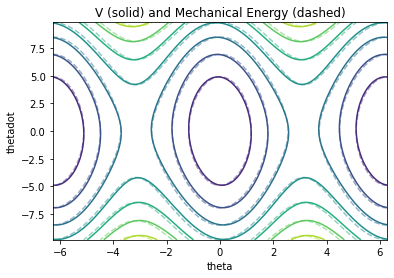

In [271]:
from pydrake.examples.pendulum import PendulumParams

def global_pendulum():
    prog = MathematicalProgram()

    # Declare the "indeterminates", x.  These are the variables which define the
    # polynomials, but are NOT decision variables in the optimization.  We will
    # add constraints below that must hold FOR ALL x.
    s = prog.NewIndeterminates(1, "s")[0]
    c = prog.NewIndeterminates(1, "c")[0]
    thetadot = prog.NewIndeterminates(1, "thetadot")[0]
    # TODO(russt): bind the sugar methods so I can write
    #  x = prog.NewIndeterminates(["s", "c", "thetadot"])
    x = np.array([s, c, thetadot])

    # Write out the dynamics in terms of sin(theta), cos(theta), and thetadot
    p = PendulumParams()
    f = [
        c * thetadot, -s * thetadot,
        (-p.damping() * thetadot - p.mass() * p.gravity() * p.length() * s) /
        (p.mass() * p.length() * p.length())
    ]

    # The fixed-point in this coordinate (because cos(0)=1).
    x0 = np.array([0, 1, 0])

    # Construct a polynomial V that contains all monomials with s,c,thetadot up
    # to degree 2.
    deg_V = 2
    V = prog.NewFreePolynomial(Variables(x), deg_V).ToExpression()

    # Add a constraint to enforce that V is strictly positive away from x0.
    # (Note that because our coordinate system is sine and cosine, V is also zero
    # at theta=2pi, etc).
    eps = 1e-4
    constraint1 = prog.AddSosConstraint(V - eps * (x - x0).dot(x - x0))

    # Construct the polynomial which is the time derivative of V.
    Vdot = V.Jacobian(x).dot(f)

    # Construct a polynomial L representing the "Lagrange multiplier".
    deg_L = 2
    L = prog.NewFreePolynomial(Variables(x), deg_L).ToExpression()

    # Add a constraint that Vdot is strictly negative away from x0 (but make an
    # exception for the upright fixed point by multipling by s^2).
    constraint2 = prog.AddSosConstraint(-Vdot - L * (s**2 + c**2 - 1) - eps *
                                        (x - x0).dot(x - x0) * s**2)
    # TODO(russt): When V is the mechanical energy, Vdot=-b*thetadot^2, so I may not need all of the multipliers here.                  

    # Add V(0) = 0 constraint
    constraint3 = prog.AddLinearConstraint(
        V.Substitute({
            s: 0,
            c: 1,
            thetadot: 0
        }) == 0)

    # Add V(theta=pi) = mgl, just to set the scale.
    constraint4 = prog.AddLinearConstraint(
        V.Substitute({
            s: 1,
            c: 0,
            thetadot: 0
        }) == p.mass() * p.gravity() * p.length())

    # Call the solver.
    result = Solve(prog)
    assert result.is_success()

    # Note that I've added mgl to the potential energy (relative to the textbook),
    # so that it would be non-negative... like the Lyapunov function.
    mgl = p.mass() * p.gravity() * p.length()
    print("Mechanical Energy = ")
    print(.5 * p.mass() * p.length()**2 * thetadot**2 + mgl * (1 - c))

    print("V =")
    Vsol = Polynomial(result.GetSolution(V))
    print(Vsol.RemoveTermsWithSmallCoefficients(1e-6))

    # Plot the results as contour plots.
    nq = 151
    nqd = 151
    q = np.linspace(-2 * np.pi, 2 * np.pi, nq)
    qd = np.linspace(-2 * mgl, 2 * mgl, nqd)
    Q, QD = np.meshgrid(q, qd)
    Energy = .5 * p.mass() * p.length()**2 * QD**2 + mgl * (1 - np.cos(Q))
    Vplot = Q.copy()
    env = {s: 0., c: 1., thetadot: 0}
    for i in range(nq):
        for j in range(nqd):
            env[s] = np.sin(Q[i, j])
            env[c] = np.cos(Q[i, j])
            env[thetadot] = QD[i, j]
            Vplot[i, j] = Vsol.Evaluate(env)

    # plt.rc("text", usetex=True)
    fig, ax = plt.subplots()
    ax.contour(Q, QD, Vplot)
    ax.contour(Q, QD, Energy, alpha=0.5, linestyles="dashed")
    ax.set_xlabel("theta")
    ax.set_ylabel("thetadot")
    ax.set_title("V (solid) and Mechanical Energy (dashed)")

global_pendulum()